# Ce notebook explore la comparaison de gros documents avec le pipeline de RAG

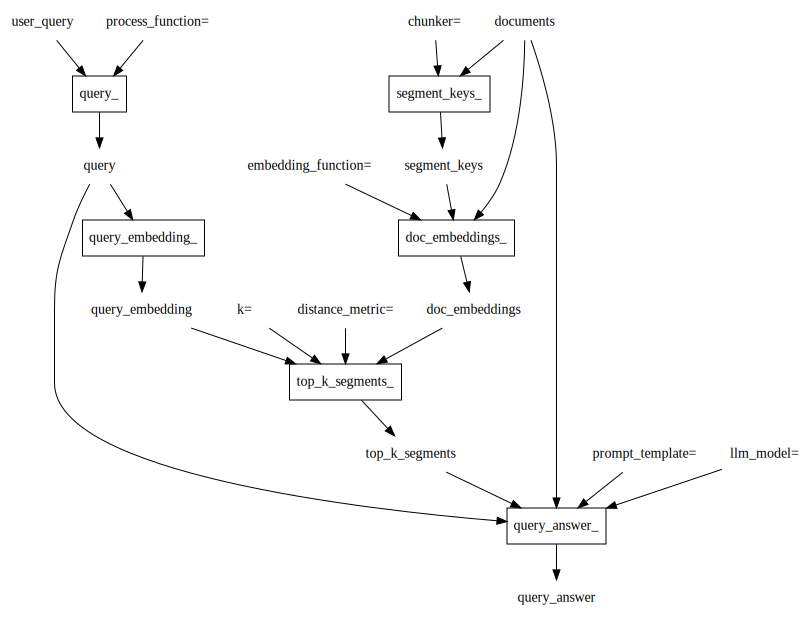

In [4]:
from raglab.retrieval.lib_alexis import dag
dag.dot_digraph()

Création d'un store sur les fichiers de contracts

In [5]:
from i2 import Namespace
from dol import Files
from raglab.retrieval.lib_alexis import extension_base_wrap
folder_path = "/Users/alexis/Documents/GitHub/rag_sante/contracts/"

mall = Namespace(contracts = extension_base_wrap(Files(folder_path)))

In [6]:
# tous les contracts dans le dossier
list(mall.contracts)

['240402 Axeptio X ADDIX GROUP - Conditions generales de partenariat anglais francais 050424[228731].pdf',
 'Contrat + Bons de commande-Antoine NASSIF + Pierre TCHEKOUTEU-301223.pdf',
 'Contrat AddixWare GreenCom Networks_V2.pdf',
 'Contrat PSI_ADDIXWARE (Mathilde Chenillot) (1).pdf',
 'Contrat d_assistance technique-Axeptio-ADW [60][228732].pdf',
 'Contrat_ONE140623_Dvlpmt UO & KPI Pilotage Site SAFRAN Châtellerault_2023 07 21 (signed).pdf',
 'Avenant Contrat AddixWare GreenCom Networks_V2.pdf',
 'Annexe 3 CP - Schneider 2021 - V2.pdf']

création d'un mapping pour les documents (à stocker dans un DB)

In [7]:
documents = dict(mall.contracts)

Sélection de 2 contracts

In [8]:
selection  = ["240402 Axeptio X ADDIX GROUP - Conditions generales de partenariat anglais francais 050424[228731].pdf", "Contrat PSI_ADDIXWARE (Mathilde Chenillot) (1).pdf"]
selected_docs = dict({
    key: value for key, value in documents.items() if key in selection}
)

selected_docs

{'240402 Axeptio X ADDIX GROUP - Conditions generales de partenariat anglais francais 050424[228731].pdf': 'c.Le Partenaire peut cependant sous-traiter certaines de ses\nAgilita\'on – Condi\'ons générales de partenariat missions, sous réserve du respect des règles qui s’appliquent\nà ce cas de figure dans le Contrat.\n1.Défini\'ons de certains termes applicables aux CGP\n6.Personnel référant, désigna\'on & remplacement.\na.Dans les CGP, certains termes font l’objet d’une défini:on\na.Les par:es peuvent désigner chacune une personne\nprévue dans cet ar:cle afin d’éviter toute ambigüité entre les\nréférente sur les projets en cours pour fluidifier les échanges.\npar:es quant à leur significa:on exacte.\nb. Ces personnes doivent alors être en mesure d’accepter ou\nb.Ces défini:ons s’imposent donc aux Par:es : Annexe(s) : de refuser rapidement les proposi:ons techniques\ndésigne le(s) document(s) que les parEes rédigent proposées par le Partenaire et de faire les choix nécessaires\nséparém

Embeddings des documents selectionnés

In [9]:
selection_embedding = dag[:"doc_embeddings"](selected_docs) # can change the chunker

In [10]:
# iterate through One document
doc1_embedding = {key: value for key, value in selection_embedding.items() if key[0] == selection[0]}
doc2_embedding = {key: value for key, value in selection_embedding.items() if key[0] == selection[1]}

Créations d'une corresponce par clés des segments à comparer

In [11]:
to_compare_list = []
for key, value in doc1_embedding.items():
    key_to_compare = dag["query_embedding":"top_k_segments"](query_embedding = value, k = 3, doc_embeddings = doc2_embedding)
    to_compare_list.append( key_to_compare)

    print(f"\nsegment of doc1 {key[1:3]} to be compared with segments:")
    for key2 in key_to_compare:
        print(f"segment of doc2 {key2[1:3]}")
    
z = zip(doc1_embedding.keys(), to_compare_list) # tuples : (key of doc1, list of keys of doc2 to compare)


segment of doc1 (0, 2998) to be compared with segments:
segment of doc2 (28896, 31869)
segment of doc2 (2900, 5809)
segment of doc2 (0, 2923)

segment of doc1 (2937, 5923) to be compared with segments:
segment of doc2 (2900, 5809)
segment of doc2 (5732, 8677)
segment of doc2 (28896, 31869)

segment of doc1 (5850, 8748) to be compared with segments:
segment of doc2 (8658, 11629)
segment of doc2 (11540, 14531)
segment of doc2 (5732, 8677)

segment of doc1 (8687, 11629) to be compared with segments:
segment of doc2 (28896, 31869)
segment of doc2 (37627, 40580)
segment of doc2 (31789, 34746)

segment of doc1 (11630, 14622) to be compared with segments:
segment of doc2 (31789, 34746)
segment of doc2 (34732, 37715)
segment of doc2 (37627, 40580)

segment of doc1 (14554, 17501) to be compared with segments:
segment of doc2 (37627, 40580)
segment of doc2 (34732, 37715)
segment of doc2 (31789, 34746)

segment of doc1 (17439, 20433) to be compared with segments:
segment of doc2 (37627, 40580)
s

comparaisons

In [12]:
from raglab.retrieval.lib_alexis import query_answer
z = zip(doc1_embedding.keys(), to_compare_list) # tuples : (key of doc1, list of keys of doc2 to compare)
# comparaisons = []
comparaison_txt = ""
for id1, list_id2 in z:
  comparison = query_answer(query=documents[id1[0]][id1[1]:id1[2]],
                            documents=documents,
                              top_k_segments=list_id2,
                            prompt_template="compare le document 1: {query} avec le document2 : {documents} en francais"
  )
  # comparaisons.append(comparison)
  comparaison_txt += comparison + "\n\n"

# with open("comparaisons.txt", "w") as f:
#   for comparison in comparaisons:
#     f.write(comparison)
#     f.write("\n\n")

aggregation des comparaisons

In [21]:
from oa import prompt_function
template = "Je vais te donner des comparaisons entre des documents. Tu doit mettre en forme et réécrire toutes les comparaisons faites en évitant les répétitions. Voici les comparaisons entre 2 documents: {comparaisons}"
f = prompt_function(template)

In [22]:
res = f(comparaison_txt)

In [23]:
res

"Les deux contrats de prestation de services entre des sociétés partagent des similitudes dans leurs clauses spécifiques, avec des points en commun tels que la durée du contrat, les obligations des parties, et les définitions des termes utilisés. Ils mettent tous deux l'accent sur la collaboration active entre les parties et l'importance de respecter les réglementations en vigueur dans le cadre de leurs relations contractuelles.\n\nLes documents 1 et 2 présentent des références communes aux obligations générales des parties, aux objectifs du contrat, à la collaboration entre les parties, à la propriété intellectuelle, et à la durée du contrat. Cependant, le document 2 se distingue par sa structuration plus claire et détaillée, abordant spécifiquement les obligations des parties, le lieu d'exécution des prestations, la propriété intellectuelle, les conditions particulières, et une annexe dédiée aux sous-traitants traitant des données du groupe.\n\nLe document 2 se montre également plus 

## Essai de pipeline RAG sur les contracts pour le question/reponse

In [14]:
responce = dag[:"top_k_segments"](documents=documents, user_query="quel est la reglementation pour les déjeunés en entreprise. Où doivent s'effectuer les repas?", k=1)
responce = responce[0]
print(documents[responce[0]][responce[1]:responce[2]])